# Fifa World Cup 2018 - Prediction

## Brainstorming

This section is dedicated to the Exploratory Data Analysis and brainstoriming on possible faetures and problem formulation.

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
%matplotlib inline

### Dataset 1: [International football results from 1872 to 2018](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017/data):

This data set contains the results of internation games for the past 146 years.

AG: Let's import the main data set(international games).
With this we can get some data for all the available games till now.
Especially the last 2 decades of these data can be used to extract some useful information for each team. These are the features I think we can get out of this data:

- Win to lose ratio total
- Win to lose ration general
- Mean goal scored ( **this can be used to define weather team is defensive or not** )
- Mean goal recieved ( **this can be used to define weather team is offensive or not** )

In [81]:
international_matches = pd.read_csv('international_matches.zip', compression='zip', header=0, sep=',', quotechar='"', date_parser='date').set_index('date')

In [82]:
international_matches.head()

,home_team,away_team,home_score,away_score,tournament,city,country
date,,,,,,,
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1873-03-08,England,Scotland,4,2,Friendly,London,England
1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
1875-03-06,England,Scotland,2,2,Friendly,London,England
1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


In [83]:
international_matches.loc['2015':'2018'].shape

(2681, 7)

We have 2681 records in last 4 years from which we can use 3 years for traning and 1 year for prediction.

 ### Initial content's dataset

In [84]:
international_matches.head()

,home_team,away_team,home_score,away_score,tournament,city,country
date,,,,,,,
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland
1873-03-08,England,Scotland,4,2,Friendly,London,England
1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland
1875-03-06,England,Scotland,2,2,Friendly,London,England
1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland


In [85]:
def process_team(row,type_team_prefix='home'):
    
    contrary_type = {
        "home": "away",
        "away": "home"
    }
    
    # Creating variables to handle 'home' and 'away' teams independently
    type_team = type_team_prefix + '_team'
    contrary_team = contrary_type.get(type_team_prefix) + '_team'
    
    type_team_score = type_team_prefix + '_score'
    contrary_team_score = contrary_type.get(type_team_prefix) + '_score'
    
    current_team = row[type_team]
    
    victory = row[type_team_score] > row[contrary_team_score]
    lose = row[type_team_score] < row[contrary_team_score]
    tie = row[type_team_score] == row[contrary_team_score]
    
    goals_scored = row[type_team_score]
    goals_received = row[contrary_team_score]
    
    if current_team not in all_series:
        
        serie_team = {
            "Team": current_team, 
            "Victories": int(victory), 
            "Loses": int(lose), 
            "Ties": int(tie), 
            "Ratio(win/lose)": 0, 
            "Goals(scored)": goals_scored, 
            "Goals(received)": goals_received
        }
        
        all_series[current_team] = serie_team
        
    else:
        
        if victory:
            all_series[current_team]['Victories'] += 1
        elif lose:
            all_series[current_team]['Loses'] += 1
        else:
            all_series[current_team]['Ties'] += 1
            
        all_series[current_team]['Goals(scored)'] += goals_scored
        all_series[current_team]['Goals(received)'] += goals_received

In [86]:
all_series = {}

for i , row in international_matches.iterrows():
    process_team(row,'home')
    process_team(row,'away')

In [87]:
columns = ["Team","Victories","Loses","Ties","Ratio(win/lose)", "Goals(scored)","Goals(received)"]

infos_teams = pd.DataFrame(list(all_series.values()),columns=columns)
infos_teams.head()

,Team,Victories,Loses,Ties,Ratio(win/lose),Goals(scored),Goals(received)
0,Scotland,361,233,165,0,1318,927
1,England,552,185,238,0,2132,961
2,Wales,197,301,138,0,799,1063
3,Northern Ireland,158,322,144,0,656,1188
4,USA,280,239,140,0,947,893


In [88]:
infos_teams['Ratio(win/lose)'] = infos_teams.Victories / infos_teams.Loses
infos_teams.sort_values('Ratio(win/lose)', ascending = False).head(10)
infos_teams['total_games'] = infos_teams.Victories + infos_teams.Loses + infos_teams.Ties

> Now we will normalize the columns. The reason is that some teams play much more than other and number of victories itself cannot show their strength. **

In [89]:
infos_teams.head()
infos_teams.columns
normalizing_columns = ['Victories', 'Loses', 'Ties',
       'Goals(scored)', 'Goals(received)'] # thse columns need to be normalized

for column in normalizing_columns:
    infos_teams[column] = round(infos_teams[column] / infos_teams['total_games'],4)

In [90]:
infos_teams.sort_values(['Ratio(win/lose)'],ascending=False).head(15)

,Team,Victories,Loses,Ties,Ratio(win/lose),Goals(scored),Goals(received),total_games
224,Jersey,0.5714,0.1429,0.2857,4.000000,1.5238,1.0476,21
24,Brazil,0.6363,0.1622,0.2015,3.921569,2.1877,0.9226,943
34,Spain,0.5823,0.1901,0.2275,3.062992,1.9865,0.9027,668
1,England,0.5662,0.1897,0.2441,2.983784,2.1867,0.9856,975
15,Germany,0.5862,0.2080,0.2058,2.818653,2.2435,1.1541,928
82,Croatia,0.5358,0.1945,0.2696,2.754386,1.7474,0.9522,293
86,Iran,0.5432,0.1979,0.2589,2.744681,1.8442,0.8147,475
18,Italy,0.5256,0.1931,0.2813,2.721854,1.6982,0.9757,782
7,Argentina,0.5391,0.2135,0.2474,2.524752,1.8721,1.0455,946
101,Korea Republic,0.5265,0.2169,0.2566,2.427778,1.7687,0.9108,830


> Now we will add the name of the contients to the columns. **

In [91]:
country_continent = pd.read_csv('Countries_Continents.csv')
country_continent[country_continent.Team == 'Scotland']

,Continent,Team
122,Europe,Scotland


In [92]:
infos_teams = infos_teams.merge(country_continent, on ='Team', how = 'left').sort_values(['Ratio(win/lose)'],ascending=False)
infos_teams.sort_values(['Ratio(win/lose)'],ascending=False).head(15)

,Team,Victories,Loses,Ties,Ratio(win/lose),Goals(scored),Goals(received),total_games,Continent
224,Jersey,0.5714,0.1429,0.2857,4.000000,1.5238,1.0476,21,NaN
24,Brazil,0.6363,0.1622,0.2015,3.921569,2.1877,0.9226,943,South America
34,Spain,0.5823,0.1901,0.2275,3.062992,1.9865,0.9027,668,Europe
1,England,0.5662,0.1897,0.2441,2.983784,2.1867,0.9856,975,NaN
15,Germany,0.5862,0.2080,0.2058,2.818653,2.2435,1.1541,928,Europe
82,Croatia,0.5358,0.1945,0.2696,2.754386,1.7474,0.9522,293,Europe
86,Iran,0.5432,0.1979,0.2589,2.744681,1.8442,0.8147,475,Asia
18,Italy,0.5256,0.1931,0.2813,2.721854,1.6982,0.9757,782,Europe
7,Argentina,0.5391,0.2135,0.2474,2.524752,1.8721,1.0455,946,South America
101,Korea Republic,0.5265,0.2169,0.2566,2.427778,1.7687,0.9108,830,NaN


> Now we will test the results generated. We use the ```Victory``` attribute from **England** and **USA **

In [93]:
victory_england_as_home_team = (international_matches.home_team == 'England') & (international_matches.home_score > international_matches.away_score)
victory_england_as_away_team = (international_matches.away_team == 'England') & (international_matches.away_score > international_matches.home_score)

victory_usa_as_home_team = (international_matches.home_team == 'USA') & (international_matches.home_score > international_matches.away_score)
victory_usa_as_away_team = (international_matches.away_team == 'USA') & (international_matches.away_score > international_matches.home_score)

In [94]:
print("Victories England: {}".format(len(international_matches[victory_england_as_home_team | victory_england_as_away_team])))
print("Victories USA: {}".format(len(international_matches[victory_usa_as_home_team | victory_usa_as_away_team])))

Victories England: 552
Victories USA: 280


### Yes!! We did process the initial file to find each attribute's team to discover your victories, ties and loses as well as your goals scored and received.

### Dataset 2: fifa 2018 schedule

> This dataset consist of all the games in the upcoming matches. What we are thinking of getting from this data is the name of the participating teams. Moreover, eventually we use them to predict all of the games and the champion.

In [95]:
fifa2018 = pd.read_csv('fifa2018.csv')

In [96]:
counteris2018 = fifa2018['Home Team'].unique()[:32]

In [97]:
counteris2018

array(['Russia', 'Egypt', 'Morocco', 'Portugal', 'France', 'Argentina',
       'Peru', 'Croatia', 'Costa Rica', 'Germany', 'Brazil', 'Sweden',
       'Belgium', 'Tunisia', 'Colombia', 'Poland', 'Uruguay', 'Iran',
       'Denmark', 'Nigeria', 'Serbia', 'Korea Republic', 'England',
       'Japan', 'Saudi Arabia', 'Spain', 'Australia', 'Iceland', 'Mexico',
       'Switzerland', 'Senegal', 'Panama'], dtype=object)

### Dataset 3: [FIFA 18 Complete Player Dataset](https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset/data):

> The dataset contains all the statistics and playing attributes of all the players in the Full version of FIFA 18.
Data Source. The data is scraped from the website https://sofifa.com by extracting the Player personal data and Player Ids and then the playing and style statistics.

In [153]:
players = pd.read_csv('players.csv',low_memory=False )
all_columns = ['Name', 'Age','Nationality', 
       'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Acceleration', 'Aggression', 'Agility', 'Balance',
       'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling',
       'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling',
       'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy',
       'Interceptions', 'Jumping', 'Long passing', 'Long shots',
       'Marking', 'Penalties', 'Positioning', 'Reactions',
       'Short passing', 'Shot power', 'Sliding tackle', 'Sprint speed',
       'Stamina', 'Standing tackle', 'Strength', 'Vision', 'Volleys',
       'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID', 'LAM', 'LB', 'LCB', 'LCM',
       'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'Preferred Positions', 'RAM',
       'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST']

Some columns we might be intersted in are, overall : overal rating, potential : potential, Value : players market value, Name, Age, Nationality.

In [154]:
col2keep = ['Name','Age','Nationality', 'Overall', 'Potential', 'Value']
players = players [col2keep]

In [155]:
def floater(x):
    if len(x)>3:
        return float(x[1:-1])
    else:
        return np.nan

players.Value = players.fillna(np.nan).Value.apply(floater)

In [231]:
players[['Overall', 'Potential', 'Age']] = players[['Overall', 'Potential', 'Age']].astype('float')

In [171]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17981 entries, 0 to 17980
Data columns (total 6 columns):
Name           17981 non-null object
Age            17981 non-null int64
Nationality    17981 non-null object
Overall        17981 non-null float64
Potential      17981 non-null float64
Value          16433 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 842.9+ KB


> We will pick the top 20 players in each country, based on their overall power and assume that this is the team that their coach will choose.
We would like to get some statistics from these players.

In [232]:
country_top_players = players.sort_values('Overall', ascending=False).groupby('Nationality').head(23) # top 23 players
country_squad_stat = country_top_players.groupby(['Nationality'])['Overall', 'Potential', 'Value', 'Age'].aggregate({'max':'max', 'average':'mean' }).sort_values(('average','Overall'), ascending = False)

C:\ProgramData\Anaconda5\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [233]:
column_names = country_squad_stat.columns.get_level_values(0)+"_"+country_squad_stat.columns.get_level_values(1)

In [234]:
country_squad_stat.columns = column_names

In [235]:
country_squad_stat = country_squad_stat.reset_index()

In [238]:
country_squad_stat.head()

,Nationality,max_Overall,max_Potential,max_Value,max_Age,average_Overall,average_Potential,average_Value,average_Age
0,Spain,90.0,92.0,70.5,36.0,85.608696,86.913043,38.586957,28.173913
1,Germany,92.0,92.0,79.0,31.0,84.826087,86.130435,36.282609,27.173913
2,France,88.0,94.0,75.0,34.0,84.434783,87.086957,35.130435,26.956522
3,Brazil,92.0,94.0,123.0,34.0,84.304348,85.826087,32.952381,28.304348
4,Argentina,93.0,93.0,105.0,33.0,83.782609,84.913043,33.409091,28.565217


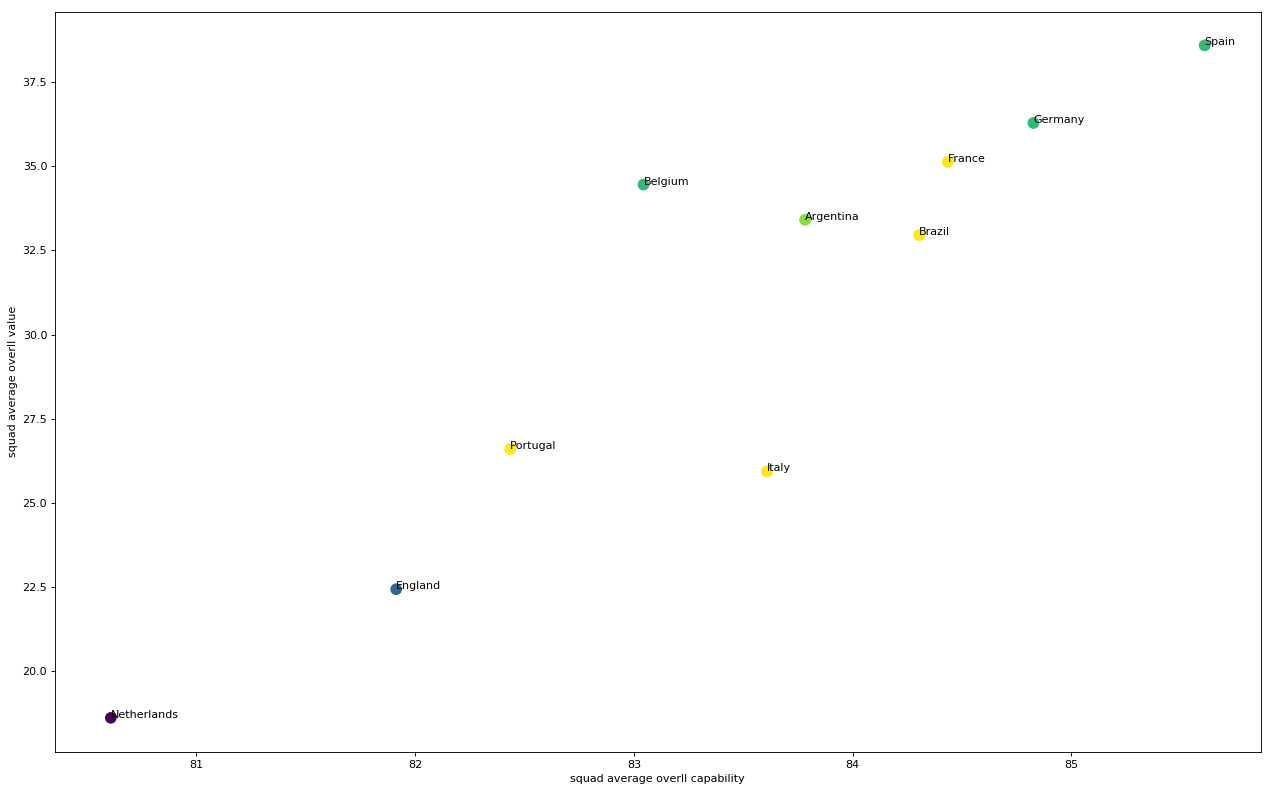

In [236]:
top10_overall = country_squad_stat.iloc[:10].average_Overall
top10_value = country_squad_stat.iloc[:10].average_Value
top10_label = country_squad_stat.iloc[:10].Nationality
s = country_squad_stat.iloc[:10].max_Potential
fig=plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(top10_overall,top10_value, s=s, c=s)
plt.xlabel('squad average overll capability')
plt.ylabel('squad average overll value')
plt.tight_layout()
for i, txt in enumerate(top10_label):
    plt.annotate(txt, (top10_overall[i],top10_value[i]))

Looking at the figure above and with a minimum knowledge of national soccer teams, we easily see that the top teams demonstrated by this dataset is quite reasonable. Next step, we will perform problem formulation based on the available data sets.

# Problem Formulation